In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root = 'data/', train = True, transform = transforms.ToTensor(), download = True)

3.9%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



102.8%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




27.1%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



112.7%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [7]:
test_data = datasets.MNIST(root='data/', train=False, download=True, transform=transform)

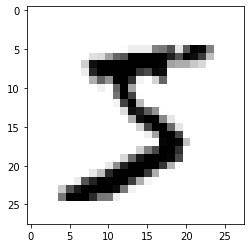

In [16]:
image,label = train_data[0]
plt.imshow(image.reshape(28,28),cmap='gist_yarg') ## para poder visualizarla tengo que hacer un reshape para que sea una matriz de 28x28 y no un vector de 784


In [17]:
torch.manual_seed(101)
batch_size = 100
train_loader= DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size = 500, shuffle=False)

In [18]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array


In [19]:
# First batch solo quiero agarrar el primer batch de imagenes 
for images,labels in train_loader:
    break

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


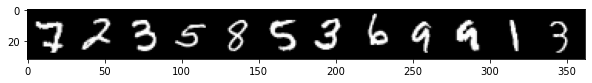

In [23]:
print( 'Labels: ', labels[:12].numpy() ) #Imprime las primeras 12 etiquetas 

im= make_grid( images[:12], nrow= 12 ) #Imprime las primeras 12 imagenes 
plt.figure( figsize= (10,4) ) #Tamaño de la figura para que se vea mas prolijo 
plt.imshow( np.transpose( im.numpy(), (1,2,0) ) )  # mueve las filas de la imagen para que el gradiente del color sea el ultimo valor de la tupla WidexHeightxColor


In [24]:
class MultilayerPerceptron(nn.Module): 
    def __init__(self, in_sz=784, out_sz=10,layers=[120,84]):
        super().__init__()

        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [25]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [26]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [29]:
images.view(100, -1) # 100 images, -1 means the rest of the dimensions are flattened

torch.Size([100, 784])

In [51]:
import time 
start_time = time.time()

#TRAINING 
epochs = 10 
#TRACKERS 
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for batch, (X_train, y_train) in enumerate(train_loader):
        batch += 1

        y_pred = model(X_train.view(100, -1)) #flatten the data 
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1] #returns the index of the max value, trae lo que predijo el modelo
        batch_corr = (predicted == y_train).sum() #cuantos aciertos hubo en el batch
        trn_corr += batch_corr #lo guardo en el tracker fuera del for 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            accuracy = trn_corr.item()*100/(100*batch)
            print(f'Epoch: {i} Batch: {batch} Loss: {loss.item()}, accuracy: {accuracy}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
        
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



total_time = time.time() - start_time
print(f'Duration: {total_time/60} minutes')

Epoch: 0 Batch: 200 Loss: 1.5362042177002877e-05, accuracy: 99.935%
Epoch: 0 Batch: 400 Loss: 0.00029181389254517853, accuracy: 99.9575%
Epoch: 0 Batch: 600 Loss: 3.4459673770470545e-05, accuracy: 99.96833333333333%
Epoch: 1 Batch: 200 Loss: 2.0196210243739188e-05, accuracy: 100.0%
Epoch: 1 Batch: 400 Loss: 2.2933940272196196e-05, accuracy: 100.0%
Epoch: 1 Batch: 600 Loss: 0.0003563010832294822, accuracy: 99.985%
Epoch: 2 Batch: 200 Loss: 3.201836807420477e-05, accuracy: 99.93%
Epoch: 2 Batch: 400 Loss: 0.03762038052082062, accuracy: 99.7975%
Epoch: 2 Batch: 600 Loss: 0.0008012417238205671, accuracy: 99.765%
Epoch: 3 Batch: 200 Loss: 0.00048739928752183914, accuracy: 99.91%
Epoch: 3 Batch: 400 Loss: 0.0008165508043020964, accuracy: 99.8625%
Epoch: 3 Batch: 600 Loss: 5.1554757192207035e-06, accuracy: 99.87833333333333%
Epoch: 4 Batch: 200 Loss: 0.00027441640850156546, accuracy: 99.945%
Epoch: 4 Batch: 400 Loss: 0.0005880030803382397, accuracy: 99.915%
Epoch: 4 Batch: 600 Loss: 4.5841720

[tensor(0.3925), tensor(0.3620), tensor(0.2928), tensor(0.3310), tensor(0.3332), tensor(0.3157), tensor(0.3938), tensor(0.3616), tensor(0.3924), tensor(0.4252)]


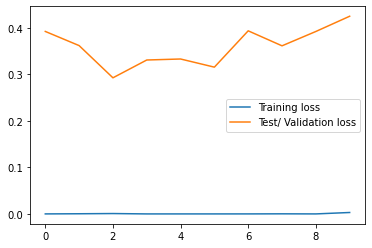

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test/ Validation loss')
plt.legend()



In [57]:
train_acc = [t/600 for t in train_correct]
train_acc

[tensor(99.9683),
 tensor(99.9850),
 tensor(99.7650),
 tensor(99.8783),
 tensor(99.9333),
 tensor(99.8850),
 tensor(99.8633),
 tensor(99.9067),
 tensor(99.9233),
 tensor(99.8850)]

In [61]:
test_acc = [t/100 for t in test_correct]
test_acc

[tensor(97.9400),
 tensor(97.7900),
 tensor(97.8300),
 tensor(97.6600),
 tensor(97.8500),
 tensor(97.6900),
 tensor(97.7500),
 tensor(97.8300),
 tensor(97.9300),
 tensor(97.7700)]

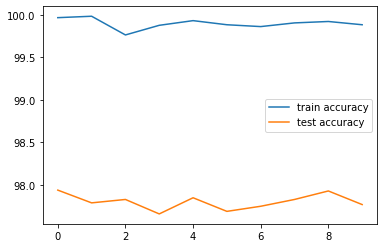

In [60]:
plt.plot(train_acc,label='train accuracy')
plt.plot(test_acc,label='test accuracy')
plt.legend()


In [62]:
#NEW UNSEEN DATA 

test_load_all  = DataLoader(test_data, batch_size=10000, shuffle=False)


In [63]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
        

In [66]:
correct.item()/len(test_data)*100

97.77

In [67]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 965,    0,    2,    0,    2,    2,    2,    1,    1,    0],
       [   0, 1125,    4,    0,    2,    0,    2,    6,    1,    5],
       [   2,    3, 1000,    3,    2,    0,    2,    8,    1,    0],
       [   1,    2,    7,  991,    1,   12,    1,    1,    5,    3],
       [   1,    0,    1,    0,  961,    2,    4,    1,    1,    9],
       [   1,    0,    0,    5,    0,  862,    8,    0,    0,    3],
       [   4,    2,    1,    0,    5,    4,  935,    1,    0,    0],
       [   2,    1,    5,    5,    1,    1,    0, 1000,    3,    4],
       [   3,    2,   12,    6,    0,    8,    4,    5,  960,    7],
       [   1,    0,    0,    0,    8,    1,    0,    5,    2,  978]])